In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

## Cartera Colectiva

In [3]:
# Reading Data
data_w = pd.read_excel('../raw_data/weekly_data_clean_with_covid_col.xlsx', engine='openpyxl')
data_d = pd.read_excel('../raw_data/daily_data_clean_with_covid_col.xlsx', engine='openpyxl')


In [4]:
# Dropping extra index column
data_w = data_w.drop(columns= 'Unnamed: 0')
data_d = data_d.drop(columns= 'Unnamed: 0')


In [5]:
#Check Nulls
data_w.isnull().sum(), data_d.isnull().sum()

(date_issue      0
 amount          0
 covid_claims    0
 dtype: int64,
 date_issue      0
 amount          0
 covid_claims    0
 dtype: int64)

In [6]:
# Check types and lenght
data_w.dtypes, len(data_w), data_d.dtypes, len(data_d)

(date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 132,
 date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 894)

In [7]:
# Setting index as date
data_w = data_w.set_index('date_issue')
data_d = data_d.set_index('date_issue')


In [8]:
data_d

,amount,covid_claims
date_issue,,
2018-09-02,14,0
2018-09-03,8716,0
2018-09-04,23504,0
2018-09-05,48112,0
2018-09-06,11508,0
...,...,...
2021-03-04,174996,15
2021-03-05,180932,23
2021-03-06,69308,17


<AxesSubplot:xlabel='date_issue'>

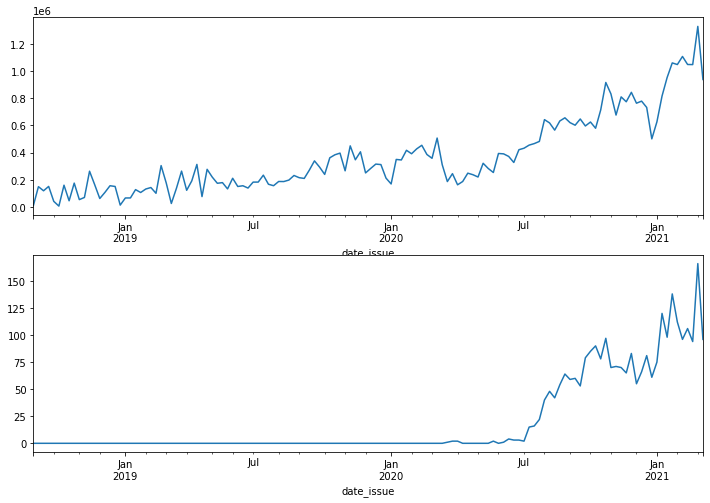

In [9]:
#Plotting weekly
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_w['amount'].plot(ax=ax1)
data_w['covid_claims'].plot(ax=ax2)


<AxesSubplot:xlabel='date_issue'>

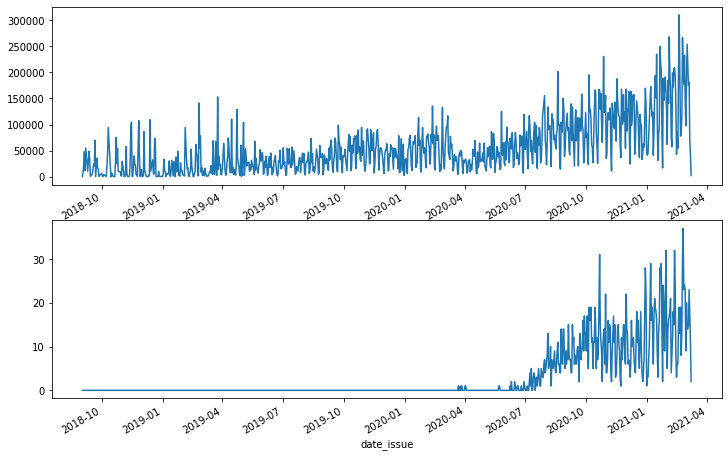

In [10]:
#Plotting daily
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_d['amount'].plot(ax=ax1)
data_d['covid_claims'].plot(ax=ax2)

### Trying with weekly data

In [11]:
# Checking for stationarity
pvalue_a = adfuller(data_w['amount'])[1]

pvalue_c = adfuller(data_w['covid_claims'])[1]

def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_a), pvalue_a, stationary(pvalue_c), pvalue_c

TS is not stationary
TS is not stationary


(None, 0.974799663931986, None, 0.991641917186487)

In [12]:
# Splitting Weekly data 

split = 0.8
split_index = round(len(data_w)*split)

train = data_w.iloc[:split_index]
test = data_w.iloc[split_index:]

train.head(1), train.tail(1), test.head(1), test.tail(1)

(            amount  covid_claims
 date_issue                      
 2018-09-03    8730             0,
             amount  covid_claims
 date_issue                      
 2020-09-07  620133            59,
             amount  covid_claims
 date_issue                      
 2020-09-14  601221            60,
             amount  covid_claims
 date_issue                      
 2021-03-08  937722            96)

In [13]:
# Separating variables
endog_train = train.drop(columns = 'covid_claims')
exog_train = train.drop(columns = 'amount')
endog_test = test.drop(columns = 'covid_claims')
exog_test = test.drop(columns = 'amount')

In [14]:
endog_test.head(1), exog_test.head(1), endog_test.tail(1), exog_test.tail(1)


(            amount
 date_issue        
 2020-09-14  601221,
             covid_claims
 date_issue              
 2020-09-14            60,
             amount
 date_issue        
 2021-03-08  937722,
             covid_claims
 date_issue              
 2021-03-08            96)

### Autoarima raw_data without exogenous variable

In [15]:
autoarima_raw = pm.auto_arima(y = endog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1416.025, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=1.27 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1373.226, Time=0.89 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1383.999, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1366.944, Time=2.23 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1364.944, Time=1.81 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1366.944, Time=5.37 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=4.80 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=1.19 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1366.263, Time=1.79 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1368.372, Time=1.81 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1367.818, Time=2.71 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1366.697, Time=1.81 sec

Best model:  ARIMA(0,1,1)(1,1,0)[52]  

In [16]:
# Split = 0.8
# Best model:  ARIMA(0,1,1)(1,1,0)[52]
# AIC = 1364


autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -679.472
Date:                             Mon, 15 Mar 2021   AIC                           1364.944
Time:                                     10:57:41   BIC                           1370.855
Sample:                                          0   HQIC                          1367.217
                                             - 106                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3933      0.320     -1.230      0.219      -1.020       0.234
ar.S.L52      -0.9625      0.256     -3.763      0.000      -1.464      -0.461
sigma2      1.386e+10    3.5e-12   3.96e+21      0.000    1.39e+10    1.39e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.86   Prob(JB):                         0.58
Heteroskedasticity (H):               1.02   Skew:                            -0.35
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [17]:
# Build model
best_sarima = SARIMAX(endog= endog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [18]:
prediction = best_sarima.get_prediction(start = '2020-09-14', end = '2021-03-08', dynamic = True, full_results = True)


In [19]:
prediction.row_labels

DatetimeIndex(['2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05',
               '2020-10-12', '2020-10-19', '2020-10-26', '2020-11-02',
               '2020-11-09', '2020-11-16', '2020-11-23', '2020-11-30',
               '2020-12-07', '2020-12-14', '2020-12-21', '2020-12-28',
               '2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25',
               '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22',
               '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [20]:
predicted_amount = prediction.prediction_results.forecasts[0]

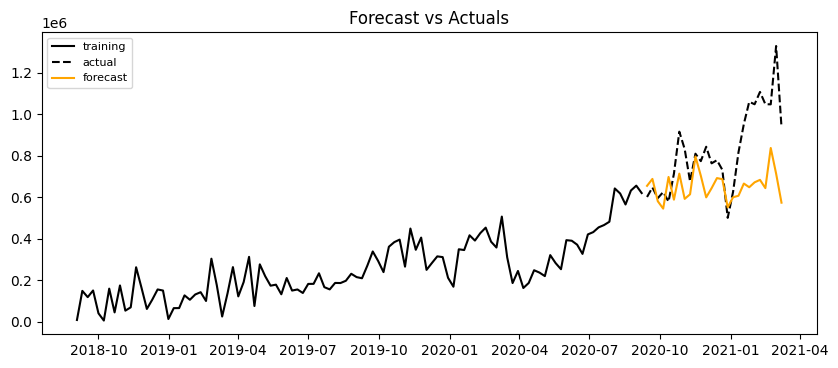

In [21]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [22]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

188141.86562099235

In [23]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.2030153991191624

In [27]:
# Creating confidence intervals

pred_ci = prediction.conf_int(alpha=0.05)

In [28]:
pred_ci.head(2)

,lower amount,upper amount
2020-09-14,424057.520921,885530.349673
2020-09-21,418319.841792,958071.889321


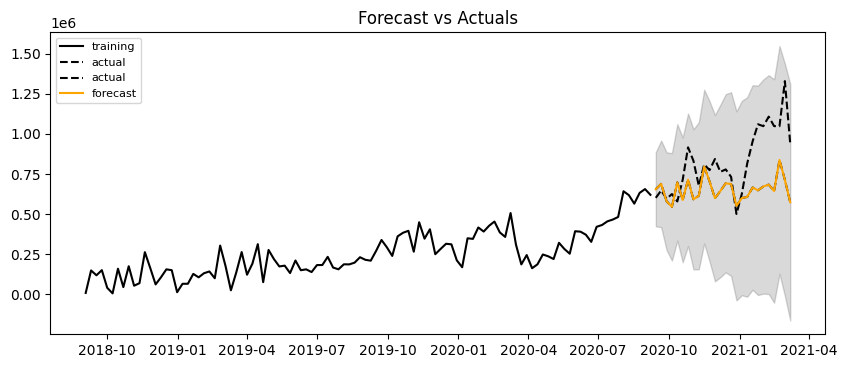

In [30]:
plot_forecast(predicted_amount, endog_train, endog_test, upper= pred_ci['upper amount'].values, lower= pred_ci['lower amount'].values)

### Best Model

SARIMAX(endog= endog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))

MAE = 188141.86562099235
MAPE = 0.203

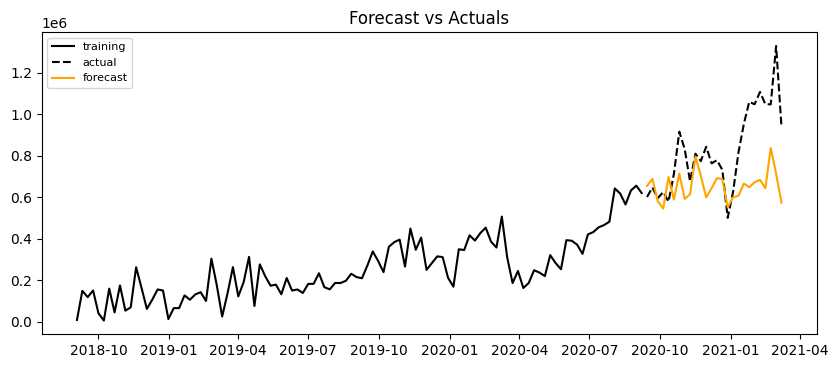

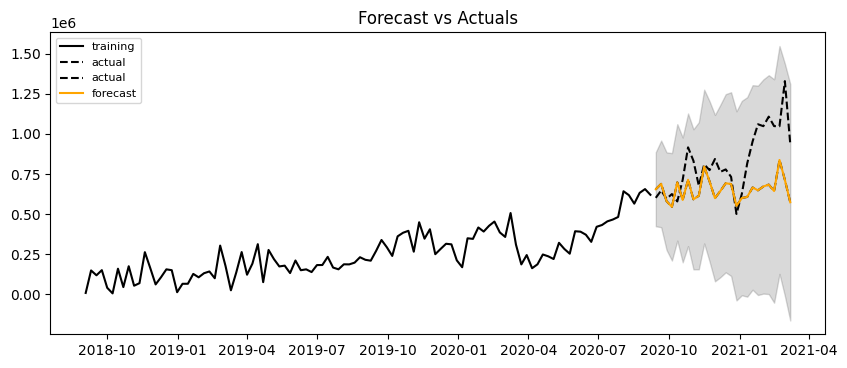